# Import libraries

In [1]:
import time
import joblib
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Display a warning message
warnings.warn("this will not show")

# Set the figure size for plots
plt.rcParams["figure.figsize"] = (10,6)

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Set the display format for floating-point numbers in dataframes
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Data Acquisition

In [3]:
# Read the data from the 'SPY.csv' file
# Set the 'Date' column as the index and parse the dates
# Drop the unnecessary columns: 'Open', 'High', 'Low', 'Adj Close', 'Volume'
spy_data = pd.read_csv('SPY.csv',
                       index_col='Date',
                       parse_dates=True
                      ).drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)


# Data Preprocessing

In [4]:
spy_data.head()

,Close
Date,
2018-09-20,293.580
2018-09-21,291.990
2018-09-24,291.020
2018-09-25,290.750
2018-09-26,289.880


In [5]:
spy_data.shape

(1257, 1)

In [6]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-09-20 to 2023-09-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [7]:
# No missing values
spy_data.isnull().sum()

Close    0
dtype: int64

In [8]:
spy_data.describe()

,Close
count,1257.000
mean,365.177
std,64.889
min,222.950
25%,299.310
50%,379.200
75%,419.510
max,477.710


In [9]:
spy_data_length = len(spy_data)
spy_data_length

1257

<Axes: xlabel='Date'>

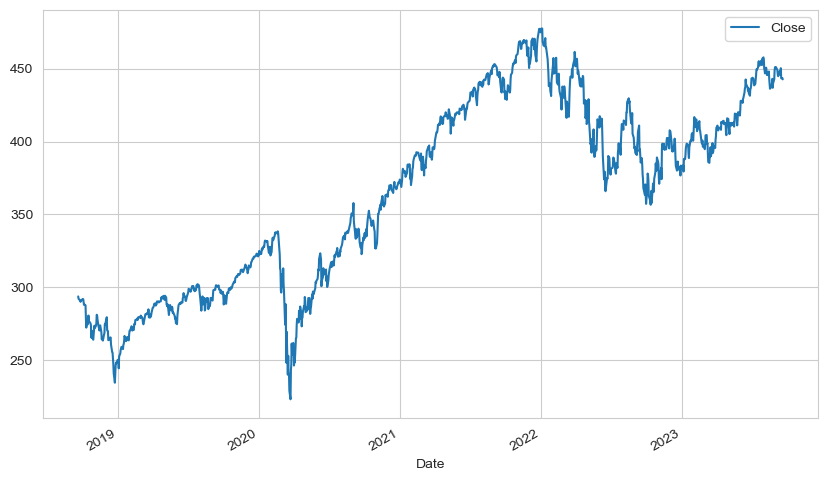

In [10]:
spy_data.plot()

In [11]:
# spliting 90% data for train and 10% fro test
test_percent = 0.1
test_point = np.round(spy_data_length*test_percent)
test_point

126.0

In [12]:
test_ind = int(spy_data_length - test_point)
test_ind

1131

In [13]:
train = spy_data['Close'].to_frame().iloc[:test_ind]
train

,Close
Date,
2018-09-20,293.580
2018-09-21,291.990
2018-09-24,291.020
2018-09-25,290.750
2018-09-26,289.880
...,...
2023-03-14,391.730
2023-03-15,389.280
2023-03-16,396.110


In [14]:
test = spy_data['Close'].to_frame().iloc[test_ind:]
test

,Close
Date,
2023-03-21,398.910
2023-03-22,392.110
2023-03-23,393.170
2023-03-24,395.750
2023-03-27,396.490
...,...
2023-09-13,446.510
2023-09-14,450.360
2023-09-15,443.370


In [15]:
# Normalize the data
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_train

array([[0.27724129],
       [0.27100014],
       [0.26719263],
       ...,
       [0.67969851],
       [0.65567592],
       [0.67039565]])

In [17]:
scaled_test = scaler.transform(test)
scaled_test

array([[0.69068932],
       [0.66399746],
       [0.66815835],
       [0.67828547],
       [0.68119013],
       [0.67769671],
       [0.70026697],
       [0.70949136],
       [0.73182612],
       [0.73794952],
       [0.72899992],
       [0.72479986],
       [0.73104102],
       [0.73268956],
       [0.7331214 ],
       [0.72656616],
       [0.74784114],
       [0.74387658],
       [0.74968602],
       [0.75074579],
       [0.75047112],
       [0.74159999],
       [0.7428561 ],
       [0.74454393],
       [0.71883339],
       [0.71208193],
       [0.74368037],
       [0.75749725],
       [0.75584871],
       [0.73751768],
       [0.72644841],
       [0.71510446],
       [0.74454393],
       [0.74497565],
       [0.73787094],
       [0.7454075 ],
       [0.7425813 ],
       [0.74046162],
       [0.74603555],
       [0.73520179],
       [0.75474964],
       [0.77045069],
       [0.76805622],
       [0.76872357],
       [0.75027478],
       [0.73849899],
       [0.75247292],
       [0.773

# Data Sequencing

In [18]:
# Set the desired length and batch size for the TimeseriesGenerator
length = 5
batch_size = 1

# Create the TimeseriesGenerator for the training data
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

# Create the TimeseriesGenerator for the validation data
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [19]:
len(generator)

1126

In [20]:
len(validation_generator)

121

In [21]:
generator.length

5

In [22]:
validation_generator.length

5

In [23]:
y_length = len(generator[0][1])
y_length

1

In [24]:
y_gen_length = len(validation_generator[0][1])
y_gen_length

1

In [25]:
# What does the first batch look like?
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.27724129 0.27100014 0.26719263 0.26613285 0.26271789]
Predict this y: 
 [[0.26589734]]


In [26]:
# What does the first batch look like?
X_gen, y_gen = validation_generator[0]
print(f'Given the Array: \n{X_gen.flatten()}')
print(f'Predict this y: \n {y_gen}')

Given the Array: 
[0.69068932 0.66399746 0.66815835 0.67828547 0.68119013]
Predict this y: 
 [[0.67769671]]


# Model Architecture

In [27]:
# In this project, we will attempt to train two types of models: GRU and LSTM. 
# We will examine the performance of both models and provide the client with the optimal model.

In [28]:
def build_model(time_steps, n_features, num_layers, rnn_type):
    """
    Build a recurrent neural network (RNN) model with the specified parameters.
    
    Parameters:
    - time_steps: int, the number of time steps in each input sequence
    - n_features: int, the number of features in each time step
    - num_layers: int, the number of RNN layers in the model
    - rnn_type: str, the type of RNN layer to use ('lstm' or 'gru')
    
    Returns:
    - model: a compiled RNN model
    
    Raises:
    - ValueError: if an invalid RNN type is specified
    
    """
    # Initialize a sequential model
    model = Sequential()
    
    # Choose the type of RNN layer
    if rnn_type == 'lstm':
        rnn_layer = LSTM
    elif rnn_type == 'gru':
        rnn_layer = GRU
    else:
        raise ValueError("Invalid RNN type. Choose either 'lstm' or 'gru'.")
    
    # Add the first RNN layer
    model.add(globals()[rnn_layer.__name__](units=50, 
                                            return_sequences=True,
                                            activation='relu',
                                            input_shape=(time_steps, n_features)))
    
    # Add intermediate RNN layers
    for _ in range(num_layers-2):
        model.add(globals()[rnn_layer.__name__](units=50, activation='relu', return_sequences=True))
        
    # Add the final RNN layer
    model.add(globals()[rnn_layer.__name__](units=50, activation='relu',  return_sequences=False))
    
    # Add a dense output layer
    model.add(Dense(units=1))
    
    return model


In [29]:
# Refers only to the Close column
n_features = 1

In [30]:
# Build a GRU model with the specified parameters
gru_model = build_model(time_steps=length, n_features=n_features, num_layers=3, rnn_type='gru')

In [31]:
# Build an LSTM model with the specified parameters
lstm_model = build_model(time_steps=length, n_features=n_features, num_layers=3, rnn_type='lstm')

In [32]:
def summarize_and_compile(model, optimizer, loss):
    """
    Summarize the model architecture and compile it with the specified optimizer and loss function.
    
    Parameters:
    - model: a Keras model object
    - optimizer: a Keras optimizer object or string specifying the optimizer
    - loss: a Keras loss function or string specifying the loss function
    
    """
    # Print a summary of the model architecture
    model.summary()
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss=loss)

In [33]:
# Set the optimizer to 'adam'
optimizer = 'adam'

# Set the loss function to 'mean_squared_error'
loss = 'mean_squared_error'

In [34]:
summarize_and_compile(gru_model, optimizer, loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 50)             7950      
                                                                 
 gru_1 (GRU)                 (None, 5, 50)             15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38601 (150.79 KB)
Trainable params: 38601 (150.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
summarize_and_compile(lstm_model, optimizer, loss)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. Model Training:

In [36]:
def train_rnn_models(generator, validation_generator, model, epochs=20, patience=5):
    """
    Trains LSTM and GRU models, compares their performance, and measures the training time.

    Parameters:
    - generator: a data generator for training data
    - validation_generator: a data generator for validation data
    - model: the RNN model to be trained
    - epochs: the number of epochs to train the model (default: 20)
    - patience: the number of epochs with no improvement after which training will be stopped (default: 5)
    """
    # Create instances of EarlyStopping callbacks for model
    model_early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    # Train model
    start_time = time.time()
    model_history = model.fit_generator(generator=generator,
                                        validation_data=validation_generator,
                                        epochs=epochs,
                                        callbacks=[model_early_stopping])
    end_time = time.time()

    print(f'The time of execution of training model is: {end_time - start_time} seconds.')

    # Plot the training and validation losses
    losses = pd.DataFrame(model.history.history)
    losses.plot()

Epoch 1/20
1126/1126 [==============================] - 10s 6ms/step - loss: 0.0064 - val_loss: 7.5197e-04
Epoch 2/20
1126/1126 [==============================] - 6s 5ms/step - loss: 0.0012 - val_loss: 4.9694e-04
Epoch 3/20
1126/1126 [==============================] - 6s 5ms/step - loss: 0.0012 - val_loss: 5.5612e-04
Epoch 4/20
1126/1126 [==============================] - 6s 6ms/step - loss: 0.0012 - val_loss: 8.2237e-04
Epoch 5/20
1126/1126 [==============================] - 6s 6ms/step - loss: 0.0011 - val_loss: 2.9175e-04
Epoch 6/20
1126/1126 [==============================] - 6s 6ms/step - loss: 9.7604e-04 - val_loss: 5.1031e-04
Epoch 7/20
1126/1126 [==============================] - 6s 6ms/step - loss: 8.8732e-04 - val_loss: 3.1019e-04
Epoch 8/20
1126/1126 [==============================] - 6s 5ms/step - loss: 7.7037e-04 - val_loss: 0.0018
Epoch 9/20
1126/1126 [==============================] - 6s 5ms/step - loss: 7.0385e-04 - val_loss: 1.5201e-04
Epoch 10/20
1126/1126 [==========

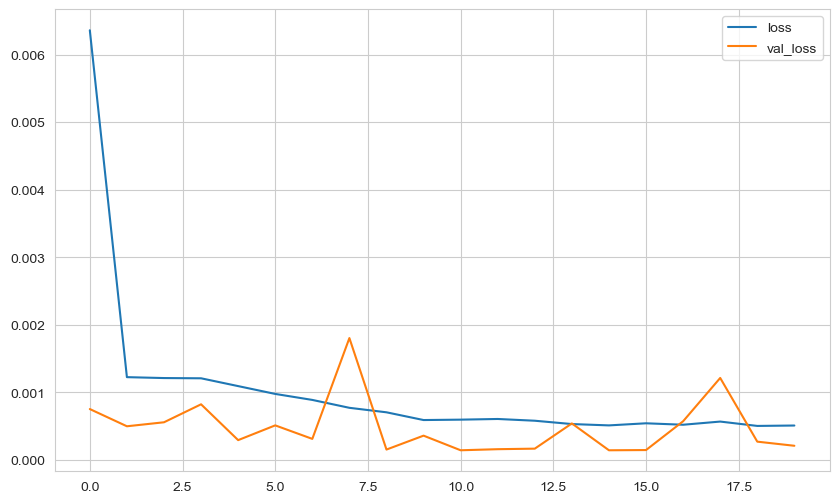

In [37]:
train_rnn_models(generator, validation_generator, gru_model)

Epoch 1/20
1126/1126 [==============================] - 12s 7ms/step - loss: 0.0102 - val_loss: 0.0027
Epoch 2/20
1126/1126 [==============================] - 6s 6ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0015 - val_loss: 9.1514e-04
Epoch 4/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0016 - val_loss: 4.9070e-04
Epoch 6/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0013 - val_loss: 5.3027e-04
Epoch 7/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 8/20
1126/1126 [==============================] - 6s 6ms/step - loss: 9.2283e-04 - val_loss: 2.5837e-04
Epoch 9/20
1126/1126 [==============================] - 7s 6ms/step - loss: 0.0010 - val_loss: 5.2927e-04
Epoch 10/20
1126/1126 [==============================] - 

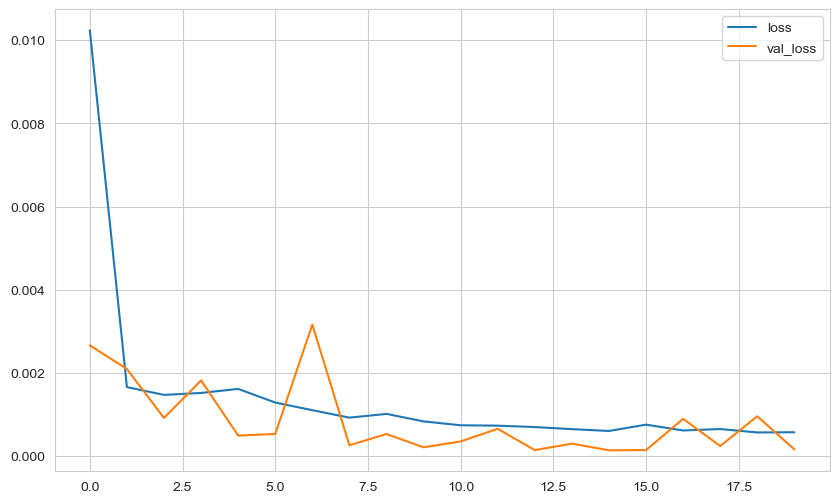

In [38]:
train_rnn_models(generator, validation_generator, lstm_model)

# Model Evaluation

In [39]:
def create_test_predictions(test, model, model_name):
    """
    Generates predictions for the test dataset using the specified model.

    Parameters:
    - test: the test dataset used for prediction
    - model: the trained model used for making predictions
    - model_name: a string indicating the name of the model

    Returns:
    - test: the test dataset with the predictions added as a new column
    """
    # Generate predictions with the trained model
    true_predictions = model.predict(validation_generator)

    # Reshape the predictions and scale them back to their original values
    true_predictions = scaler.inverse_transform(true_predictions)

    # Add the predictions as a new column in the test dataset
    model_predictions = f'{model_name}_predictions'
    test[model_predictions] = None
    test.iloc[length:, test.columns.get_loc(model_predictions)] = true_predictions

    return test

In [40]:
test = create_test_predictions(test, gru_model, 'gru_model')

121/121 [==============================] - 1s 1ms/step


In [41]:
test = create_test_predictions(test, lstm_model, 'lstm_model')

121/121 [==============================] - 0s 1ms/step


In [42]:
# Shows how the two models perform on the test set
test.iloc[length:]

,Close,gru_model_predictions,lstm_model_predictions
Date,,,
2023-03-28,395.600,399.564,398.640
2023-03-29,401.350,398.774,397.658
2023-03-30,403.700,404.227,402.928
2023-03-31,409.390,406.442,404.941
2023-04-03,410.950,411.974,409.991
...,...,...,...
2023-09-13,446.510,448.049,447.291
2023-09-14,450.360,448.837,447.916
2023-09-15,443.370,452.566,451.884


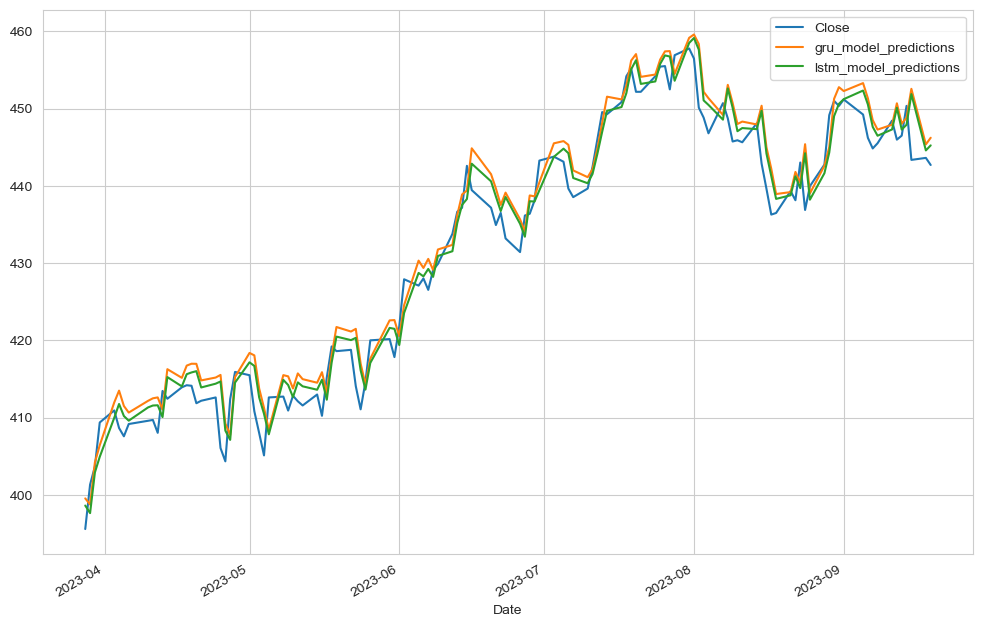

In [43]:
# A display of the model's performance
test = test.iloc[length:]
fig, ax = plt.subplots(figsize=(12, 8))
test.plot(ax=ax)
fig.savefig('plot_v2.png')

In [44]:
np.sqrt(mean_squared_error(test['Close'], test['gru_model_predictions']))

3.6752778694447055

In [45]:
mean_absolute_error(test['Close'], test['gru_model_predictions'])

3.048151181995738

In [46]:
np.sqrt(mean_squared_error(test['Close'], test['lstm_model_predictions']))

3.2121897946221543

In [47]:
mean_absolute_error(test['Close'], test['lstm_model_predictions'])

2.623788103176653

# Outcome

In both models, LSTM and GRU, the results were similar and very accurate.

Given that Gru provided better results, we will continue to work with him.

In [50]:
gru_model.save('gru_model.h5')

In [51]:
joblib.dump(scaler,'gru_scalar.pkl')

['gru_scalar.pkl']